In [1]:
# Generic
import html
import os
from pathlib import Path
import typing
import json
import os
from pathlib import Path
import typing
import html
import copy

# Transformers
import circuitsvis
from circuitsvis.attention import attention_heads
from circuitsvis.tokens import colored_tokens_multi
import matplotlib.pyplot as plt

# Numerical Computing
import numpy as np
import torch
import pandas as pd
from jaxtyping import Float, Int

# Utilities
from muutils.statcounter import StatCounter
from muutils.json_serialize import serializable_dataclass, SerializableDataclass, serializable_field

# Our Code
from maze_transformer.utils.notebook_utils import configure_notebook
from maze_transformer.generation.lattice_maze import LatticeMaze, SolvedMaze
from maze_transformer.generation.generators import LatticeMazeGenerators
from maze_transformer.dataset.tokenizer import SPECIAL_TOKENS, HuggingMazeTokenizer
from maze_transformer.training.config import ConfigHolder, ZanjHookedTransformer
from maze_transformer.evaluation.plot_maze import MazePlot, PathFormat
from maze_transformer.evaluation.eval_model import load_model_with_configs
from maze_transformer.utils.token_utils import tokens_to_coords
from maze_transformer.dataset.maze_dataset import MazeDataset, MazeDatasetConfig
from maze_transformer.dataset.maze_dataset_configs import MAZE_DATASET_CONFIGS

In [2]:
# Setup
DEVICE = configure_notebook(seed=42, dark_mode=True)
PATH_EXAMPLES: Path = Path("../examples/")
PATH_DATA: Path = Path("../data/")

# We won't be training any models
torch.set_grad_enabled(False)

MODEL_PATH: Path = PATH_EXAMPLES / "multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02/model.final.zanj"
print(f"will try to get model from {MODEL_PATH.as_posix()}")

# get the default model from examples
MODEL: ZanjHookedTransformer = ZanjHookedTransformer.read(MODEL_PATH)
print(f"loaded model: {MODEL.zanj_model_config.name} with {MODEL.num_params()} parameters")

# generate a smaller test dataset
DATASET_TEST_CFG: MazeDatasetConfig = copy.deepcopy(MODEL.zanj_model_config.dataset_cfg)
DATASET_TEST_CFG.n_mazes = 100
DATASET_TEST: MazeDataset = MazeDataset.from_config(
    DATASET_TEST_CFG,
    local_base_path=PATH_DATA,
    verbose=True,
)
print(f"got test dataset: {DATASET_TEST.cfg.name} with {len(DATASET_TEST)} mazes")

will try to get model from ../examples/multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1_2023-05-20-21-30-02/model.final.zanj
loaded model: multsrc_demo-g6-n10K-a_dfs-h92077_tiny-v1_sweep-v1 with 70319 parameters
loading dataset from ../data/demo-g6-n100-a_dfs-h88923.zanj
Got dataset demo with 100 items. output.cfg.to_fname() = 'demo-g6-n100-a_dfs-h88923'
got test dataset: demo with 100 mazes


In [3]:
@serializable_dataclass
class ProcessedMazeAttention(SerializableDataclass):
    input_maze: SolvedMaze
    tokens: list[str]
    maze_only_tokens: list[str]
    logits: Float[torch.Tensor, "n_vocab"]
    attention: dict[str, Float[torch.Tensor, "1 n_heads n_positions n_positions"]]

In [15]:
def get_attention(
	model: ZanjHookedTransformer,
	dataset: MazeDataset,
	n_mazes: int = 1,
) -> list[ProcessedMazeAttention]:

	outputs: list[ProcessedMazeAttention] = list()


	for i in range(n_mazes):
		
		# get the maze from the dataset and process into tokens
		solved_maze: SolvedMaze = dataset[i]
		tokens: list[str] = solved_maze.as_tokens(dataset.cfg.node_token_map)
		path_start_index: int = tokens.index(SPECIAL_TOKENS["path_start"])
		maze_only_tokens: list[str] = tokens[:path_start_index + 1]

		# get the model's prediction and attention data
		with torch.no_grad():
			logits, cache = model.run_with_cache(maze_only_tokens)

		# filter and append to outputs
		attention_data: dict[str, torch.Tensor] = {
			k:w 
			for k, w in cache.items() 
			# if 'hook_pattern' in k
		}
		
		outputs.append(ProcessedMazeAttention(
			input_maze=solved_maze,
			tokens=tokens,
			maze_only_tokens=maze_only_tokens,
			logits=logits,
			attention=attention_data,
		))

	return outputs


In [16]:
def plot_attention_data(data: ProcessedMazeAttention):
	n_layers: int = len(data.attention)
	example_attention_data: Float[torch.Tensor, "1 n_heads n_positions n_positions"] = data.attention[list(data.attention.keys())[0]]
	n_heads: int = example_attention_data.shape[1]
	n_tokens: int = example_attention_data.shape[2]

	attention_to_plot: Float[torch.Tensor, "n_layers n_heads n_tokens n_tokens"] = torch.concatenate(
		[w for k,w in data.attention.items()],
		dim=0,
	).reshape(-1, n_tokens, n_tokens)

	attention_head_names: list[str] = [
		f"Layer {i} Head {j}" 
		for i in range(n_layers) 
		for j in range(n_heads)
	]

	return attention_heads(
		attention_to_plot, 
		data.maze_only_tokens, 
		attention_head_names,
	)


{
  "name": "tiny-v1",
  "act_fn": "gelu",
  "d_model": 32,
  "d_head": 16,
  "n_layers": 4,
  "weight_processing": {
    "are_layernorms_folded": false,
    "are_weights_processed": true
  }
}
ATTENTION_DATA.tokens = ['<ADJLIST_START>', '(5,5)', '<-->', '(5,4)', ';', '(2,5)', '<-->', '(1,5)', ';', '(2,0)', '<-->', '(3,0)', ';', '(3,2)', '<-->', '(3,3)', ';', '(2,5)', '<-->', '(2,4)', ';', '(4,4)', '<-->', '(4,3)', ';', '(1,0)', '<-->', '(1,1)', ';', '(4,0)', '<-->', '(5,0)', ';', '(1,4)', '<-->', '(0,4)', ';', '(4,3)', '<-->', '(3,3)', ';', '(5,3)', '<-->', '(5,4)', ';', '(5,1)', '<-->', '(5,2)', ';', '(0,2)', '<-->', '(1,2)', ';', '(4,0)', '<-->', '(4,1)', ';', '(0,3)', '<-->', '(0,4)', ';', '(1,2)', '<-->', '(2,2)', ';', '(2,1)', '<-->', '(3,1)', ';', '(3,4)', '<-->', '(3,5)', ';', '(1,0)', '<-->', '(0,0)', ';', '(0,5)', '<-->', '(1,5)', ';', '(1,3)', '<-->', '(2,3)', ';', '(2,2)', '<-->', '(2,1)', ';', '(3,1)', '<-->', '(3,2)', ';', '(0,2)', '<-->', '(0,1)', ';', '(4,5)', '<-->', '

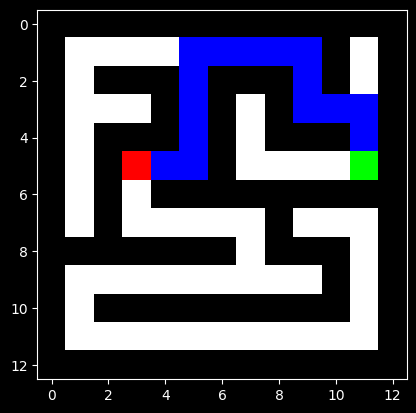

In [17]:
ATTENTION_DATA: ProcessedMazeAttention = get_attention(MODEL, DATASET_TEST, n_mazes=1)[0]

print(json.dumps(MODEL.zanj_model_config.model_cfg.summary(), indent=2))

plt.imshow(ATTENTION_DATA.input_maze.as_pixels())

print(f"{ATTENTION_DATA.tokens = }")
print(f"{ATTENTION_DATA.maze_only_tokens = }")
print(f"{ATTENTION_DATA.logits.shape = }")
print(f"{list(ATTENTION_DATA.attention.keys()) = }")
for k, v in ATTENTION_DATA.attention.items():
	print(k, v.shape)

In [ ]:
plot_attention_data(ATTENTION_DATA)

In [ ]:
#! ALEX note - there used to be a np.power(head_np, 1/4) here, not sure what that's about?
FROM_TOKEN = -1 # Look at attention from this token position to the rest of the sequence
attentions_from_token = torch.concatenate([w[0, :, FROM_TOKEN, :] for w in attentions], dim=0)
colored_tokens_multi(context_str, attentions_from_token.T, labels=attention_head_names)

In [ ]:
def prediction_contained_a_coordinate_token(tokens: list[str], tokenizer: HuggingMazeTokenizer) -> bool:
	"""Check if the prediction contains a coordinate token"""
	for t in tokens:
		if t not in list(tokenizer.special_tokens_map.values()) + tokenizer.additional_special_tokens:
			return True
	print("FAIL: Sampled a path - No coordinate token found before EOS")
	return False

predicted_tokens = []
while not prediction_contained_a_coordinate_token(predicted_tokens, model.tokenizer):
	predictions = model.generate(array_tensor, max_new_tokens=50, stop_at_eos=True, verbose=False)
	predicted_tokens = model.to_str_tokens(predictions)[len(maze_only_tokens):]
print("SUCCESS: Model predicted the path:")
print(predicted_tokens)

path_predicted: list[tuple[int,int]] = tokens_to_coords(
	predicted_tokens,
	maze_data_cfg = cfg.dataset_cfg, 
	when_noncoord = "skip",
)

# plot the maze and both solutions
# for label, fmt, color, path in paths
MazePlot(maze).add_true_path(path_true).add_predicted_path(path_predicted).plot()
plt.show()